In [ ]:
!pip install keras-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 4.3 MB/s 
     |████████████████████████████████| 5.8 MB 40.3 MB/s 
     |████████████████████████████████| 588.3 MB 5.8 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 5.9 MB 60.5 MB/s 
     |████████████████████████████████| 578.1 MB 28 kB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 4.6 MB 54.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## Preprocessing

In [ ]:
def optimize_dtypes(df):
    ints = df.select_dtypes(include=['int64', 'int32']).columns.tolist()
    floats = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    
    return df

In [ ]:
df_full = pd.read_csv("/content/drive/MyDrive/BU Projects/CS777/EEG_Project/telemetry/preprocessed_full/full data/part-00000-edd108a0-58e1-449c-ab31-394a221839a4-c000.csv")
df_full = optimize_dtypes(df_full)

In [ ]:
channels = ["fpzcz", "pzoz", "horizontal"]

In [ ]:
test_subjects = random.sample(df_full.patient.unique().tolist(), 2)

In [ ]:
df_train = df_full.loc[~df_full.patient.isin(test_subjects)]
df_test = df_full.loc[df_full.patient.isin(test_subjects)]

In [ ]:
X = df_train[channels].values
X = X.reshape(-1, 3000, len(channels))

Y = df_train.iloc[np.arange(len(df_train)) % 3000 == 0].label.values
Y = keras.utils.to_categorical(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
scaler = StandardScaler()
x_train = x_train.reshape(-1, len(channels))
scaler.fit(x_train);
x_train = scaler.transform(x_train)
x_train = x_train.reshape(-1, 3000, len(channels))

x_test = x_test.reshape(-1, len(channels))
x_test = scaler.transform(x_test)
x_test = x_test.reshape(-1, 3000, len(channels))

## Visualization Functions

### Learning Curves

In [ ]:
def plot_metrics(history):
    fig, axes = plt.subplots(1, 2, figsize=(20,5), dpi=100, facecolor="white")
    axes[0].plot(history["loss"], label="Train Loss")
    axes[0].plot(history["val_loss"], label="Val Loss")
    axes[1].plot(history["accuracy"], label="Train Accuracy")
    axes[1].plot(history["val_accuracy"], label="Val Accuracy")
    for ax in axes[:2]:
        ax.legend(loc="best", fontsize=14)
        ax.set_xlabel("Epoch", fontsize=14)
        ax.grid(linestyle=":", alpha=0.25)

### Confusion Matrix

In [ ]:
def confusion_matrix_plot(y_true, y_pred):
    
    conf_mat = confusion_matrix(y_true, y_pred)
    classes = ['Sleep Stage W', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'Sleep Stage R']
    fig, ax = plt.subplots(1,1, figsize=(4.8,4.8), dpi=100, facecolor='white')
    sns.heatmap(conf_mat, 
                ax=ax, 
                annot=True, 
                linecolor='white', 
                linewidth=1, 
                square=True, 
                fmt='d', 
                cmap='vlag_r')
    
    ax.set_xlabel("Predicted Label", fontsize=12, labelpad=15)
    ax.set_ylabel("True Label", fontsize=12, labelpad=15)
    ax.set_title("Confusion Matrix", fontsize=14, pad=15)
    ax.set_xticklabels((classes), rotation=45)
    ax.set_yticklabels((classes), rotation=0)

### Stage vs Epoch

In [ ]:
def epoch_plot(df):
  cols = {'0':'tab:blue', '1':'tab:orange', '2':'tab:green', '3':'tab:red', '4':'tab:purple'}
  classes = ['Sleep Stage W', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'Sleep Stage R']
  fig, axes = plt.subplots(2, 1, figsize=(12,10), dpi=100, sharex=True, facecolor='white')
  df = df.sort_values('y_true', ascending=False)
  sns.scatterplot(data=df, x='epoch', y='y_true', hue='y_true', ax=axes[0], palette=cols)
  df = df.sort_values('y_pred', ascending=False)
  sns.scatterplot(data=df, x='epoch', y='y_pred', hue='y_pred', ax=axes[1], palette=cols)

  
  for i in range(2):
    axes[i].set_ylabel("Sleep Stage", fontsize=10)
    axes[i].set_yticks(ticks=np.arange(5))
    axes[i].set_yticklabels(classes)
    axes[i].get_legend().remove()
  axes[0].set_xlabel("Epoch", fontsize=10)
  axes[0].set_title("True Stages", fontsize=11)
  axes[1].set_title("Predicted Stages", fontsize=11)
  patches = []
  for i in range(5):
    patches.append(mpatches.Patch(color=list(cols.values())[i], label=classes[i]))

  fig.legend(handles=patches,
             loc="center right",
             borderaxespad=0,
             title="Legend", fontsize=10);
             
  plt.suptitle("Sleep Stage vs Epoch", y=.93, fontsize=16);
  plt.subplots_adjust(hspace=0.25);

## Model

In [ ]:
from model import Sleep_Conv_Net

In [ ]:
clf = Sleep_Conv_Net(num_classes=5, 
                     head_size=256, 
                     heads=3, 
                     dim_feed_forw=128, 
                     attention_dropout=0.2)

clf.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

In [ ]:
# keras.utils.plot_model(clf, show_shapes=1)

In [ ]:
def scheduler(epoch, lr):
  if epoch >= 50:
    if (epoch - 50)%25 == 0:
      return lr*0.5 if lr*0.5 >= 1e-7 else 1e-7
  return lr

lrs = LearningRateScheduler(scheduler)

In [ ]:
history = clf.fit(x_train, y_train, epochs=200, validation_split=0.2, batch_size=32, callbacks=[lrs])

Epoch 1/200
802/802 [==============================] - 28s 20ms/step - loss: 1.3338 - accuracy: 0.4829 - val_loss: 1.6057 - val_accuracy: 0.5370 - lr: 1.0000e-05
Epoch 2/200
802/802 [==============================] - 15s 18ms/step - loss: 1.1721 - accuracy: 0.5525 - val_loss: 1.1976 - val_accuracy: 0.6044 - lr: 1.0000e-05
Epoch 3/200
802/802 [==============================] - 15s 18ms/step - loss: 1.0151 - accuracy: 0.6251 - val_loss: 1.1199 - val_accuracy: 0.5704 - lr: 1.0000e-05
Epoch 4/200
802/802 [==============================] - 15s 18ms/step - loss: 0.9507 - accuracy: 0.6492 - val_loss: 1.0366 - val_accuracy: 0.5972 - lr: 1.0000e-05
Epoch 5/200
802/802 [==============================] - 14s 18ms/step - loss: 0.9213 - accuracy: 0.6571 - val_loss: 0.8922 - val_accuracy: 0.6732 - lr: 1.0000e-05
Epoch 6/200
802/802 [==============================] - 15s 18ms/step - loss: 0.8701 - accuracy: 0.6690 - val_loss: 0.9023 - val_accuracy: 0.6434 - lr: 1.0000e-05
Epoch 7/200
802/802 [=======

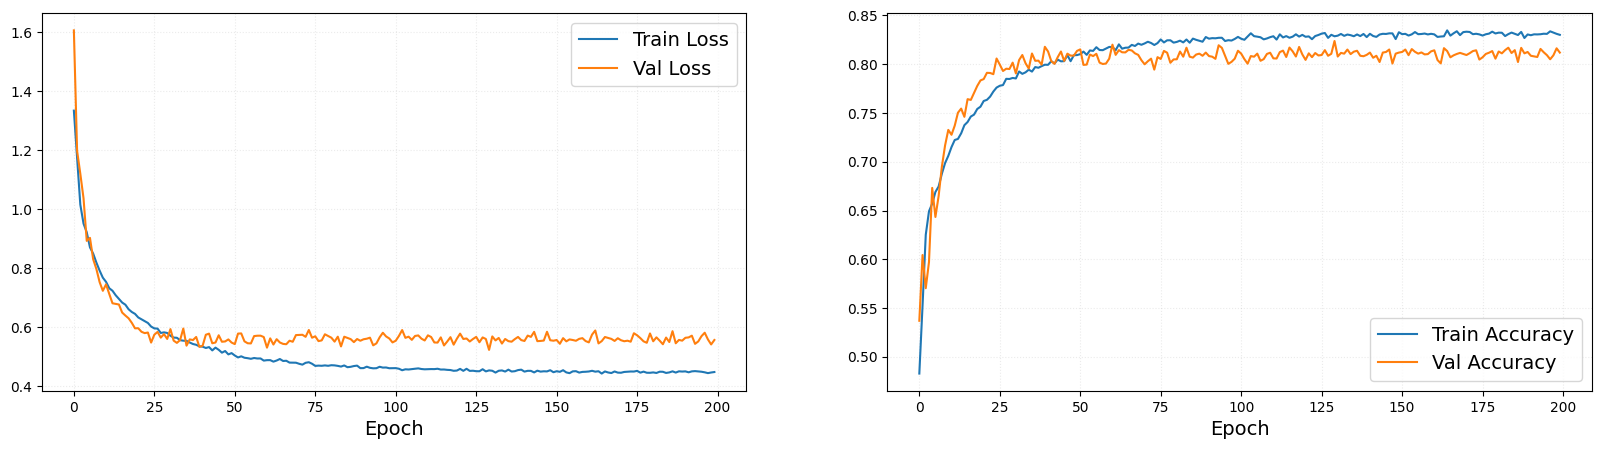

In [ ]:
plot_metrics(history.history)

In [ ]:
# clf.save_weights("/content/drive/MyDrive/BU Projects/CS777/EEG_Project/telemetry/model_weights.h5")

In [ ]:
clf.load_weights("/content/drive/MyDrive/BU Projects/CS777/EEG_Project/telemetry/model_weights.h5")

## Evaluation

In [ ]:
print(f"Test accuracy: {100*clf.evaluate(x_test, y_test, verbose=0)[1]:.2f} %")
print("\nClassification report for the test dataset:\n", classification_report(y_test.argmax(axis=-1), clf.predict(x_test, verbose=0).argmax(axis=-1)))

Test accuracy: 81.15 %

Classification report for the test dataset:
               precision    recall  f1-score   support

           0       0.71      0.92      0.80       706
           1       0.54      0.51      0.53       729
           2       0.91      0.82      0.86      3754
           3       0.70      0.92      0.80      1203
           4       0.91      0.78      0.84      1602

    accuracy                           0.81      7994
   macro avg       0.75      0.79      0.77      7994
weighted avg       0.82      0.81      0.81      7994



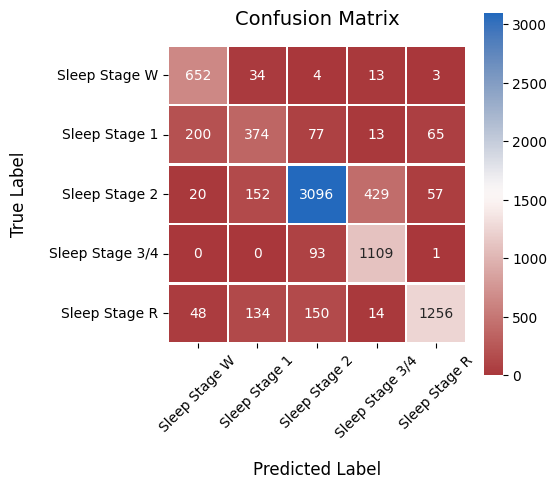

In [ ]:
confusion_matrix_plot(y_test.argmax(axis=-1), clf.predict(x_test, verbose=0).argmax(axis=-1))

### Subject 1

In [ ]:
subject_data = df_test.loc[df_test.patient == test_subjects[0]]

subject_features = subject_data[channels].values
subject_features = scaler.transform(subject_features)
subject_features = subject_features.reshape((-1, 3000, 3))

subject_labels = subject_data.iloc[np.arange(len(subject_data)) % 3000 == 0].label.values
y_true = keras.utils.to_categorical(subject_labels)

y_pred = clf.predict(subject_features, verbose=0).argmax(axis=-1)

print(f"Accuracy for test subject 1: {100*clf.evaluate(subject_features, y_true, verbose=0)[1]:.2f} %")
print("\nClassification report for test subject 1:\n", classification_report(subject_labels, y_pred))

Accuracy for test subject 1: 87.04 %

Classification report for test subject 1:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       100
           1       0.75      0.78      0.76        72
           2       0.80      0.89      0.84       303
           3       0.91      0.89      0.90       305
           4       0.96      0.80      0.87       231

    accuracy                           0.87      1011
   macro avg       0.86      0.87      0.86      1011
weighted avg       0.88      0.87      0.87      1011



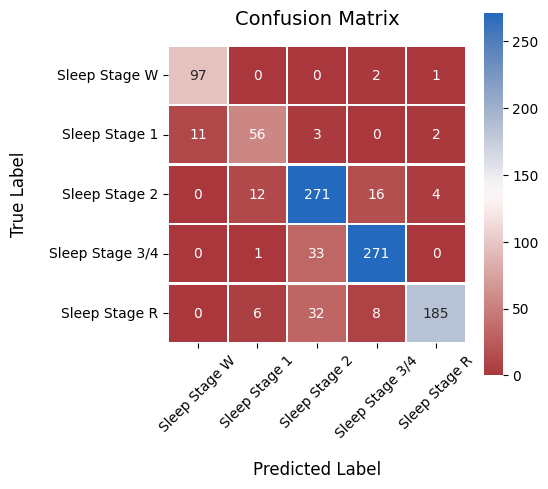

In [ ]:
confusion_matrix_plot(subject_labels, y_pred)

In [ ]:
predictions_1 = pd.DataFrame({'epoch':range(len(subject_labels)), 'y_true':subject_labels, 'y_pred':y_pred})
predictions_1['y_true'] = predictions_1['y_true'].astype(str)
predictions_1['y_pred'] = predictions_1['y_pred'].astype(str)

### Subject 2

In [ ]:
subject_data = df_test.loc[df_test.patient == test_subjects[1]]

subject_features = subject_data[channels].values
subject_features = scaler.transform(subject_features)
subject_features = subject_features.reshape((-1, 3000, 3))

subject_labels = subject_data.iloc[np.arange(len(subject_data)) % 3000 == 0].label.values
y_true = keras.utils.to_categorical(subject_labels)

y_pred = clf.predict(subject_features, verbose=0).argmax(axis=-1)

print(f"Accuracy for test subject 2: {100*clf.evaluate(subject_features, y_true, verbose=0)[1]:.2f} %")
print("\nClassification report for test subject 1:\n", classification_report(subject_labels, y_pred))

Accuracy for test subject 1: 78.58 %

Classification report for test subject 1:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79        35
           1       0.50      0.58      0.54        31
           2       0.74      0.92      0.82       401
           3       0.88      0.99      0.93       157
           4       0.88      0.47      0.62       249

    accuracy                           0.79       873
   macro avg       0.79      0.73      0.74       873
weighted avg       0.80      0.79      0.77       873



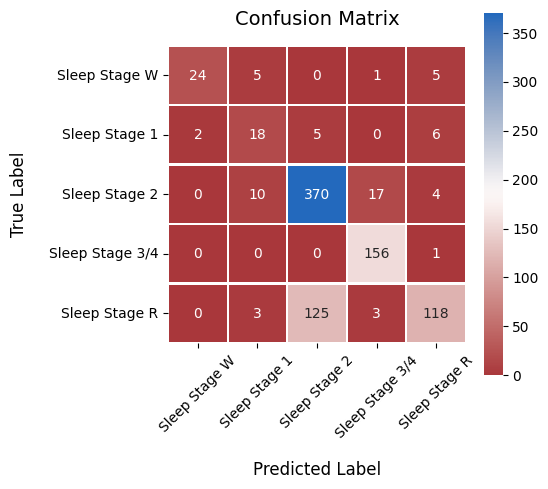

In [ ]:
confusion_matrix_plot(subject_labels, y_pred)

In [ ]:
predictions_2 = pd.DataFrame({'epoch':range(len(subject_labels)), 'y_true':subject_labels, 'y_pred':y_pred})
predictions_2['y_true'] = predictions_2['y_true'].astype(str)
predictions_2['y_pred'] = predictions_2['y_pred'].astype(str)

## Sleep Stage vs Epoch for the Test Subjects

### Subject 1

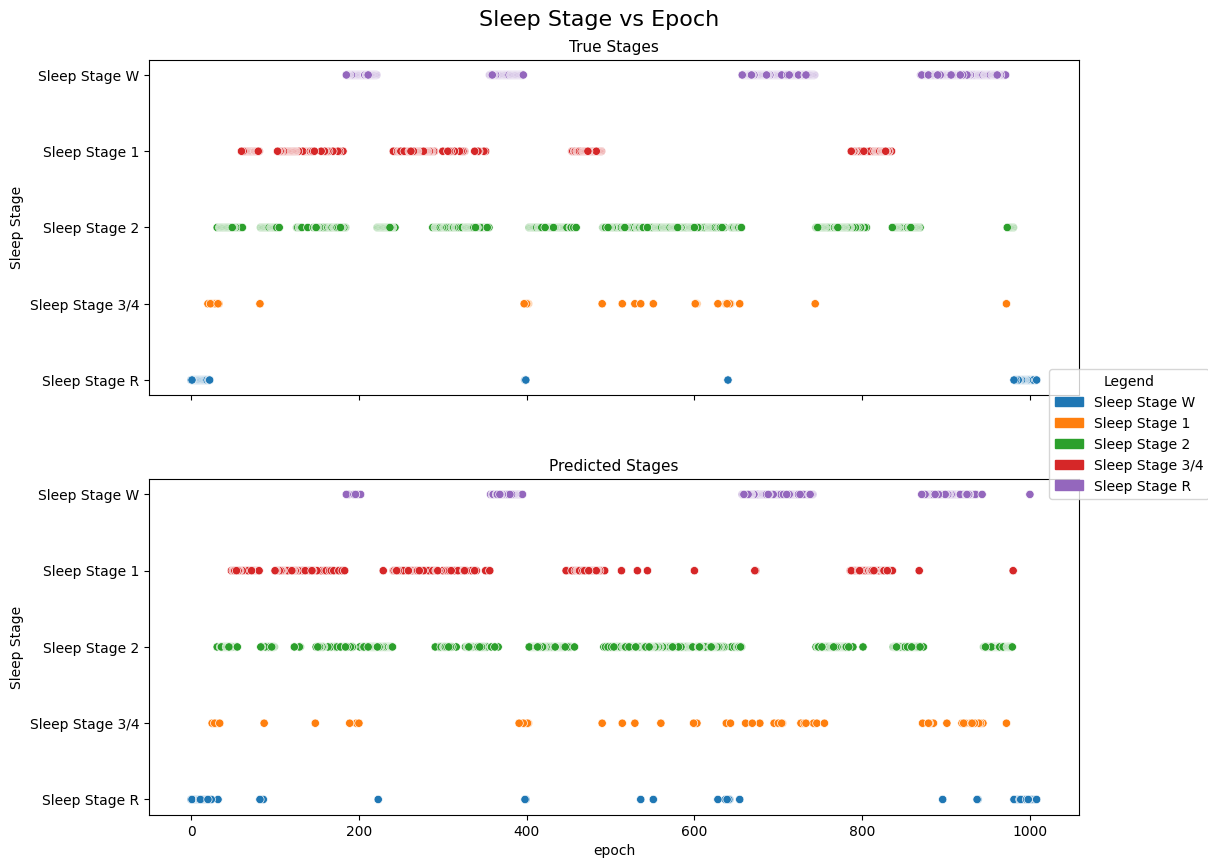

In [ ]:
epoch_plot(predictions_1)

### Subject 2

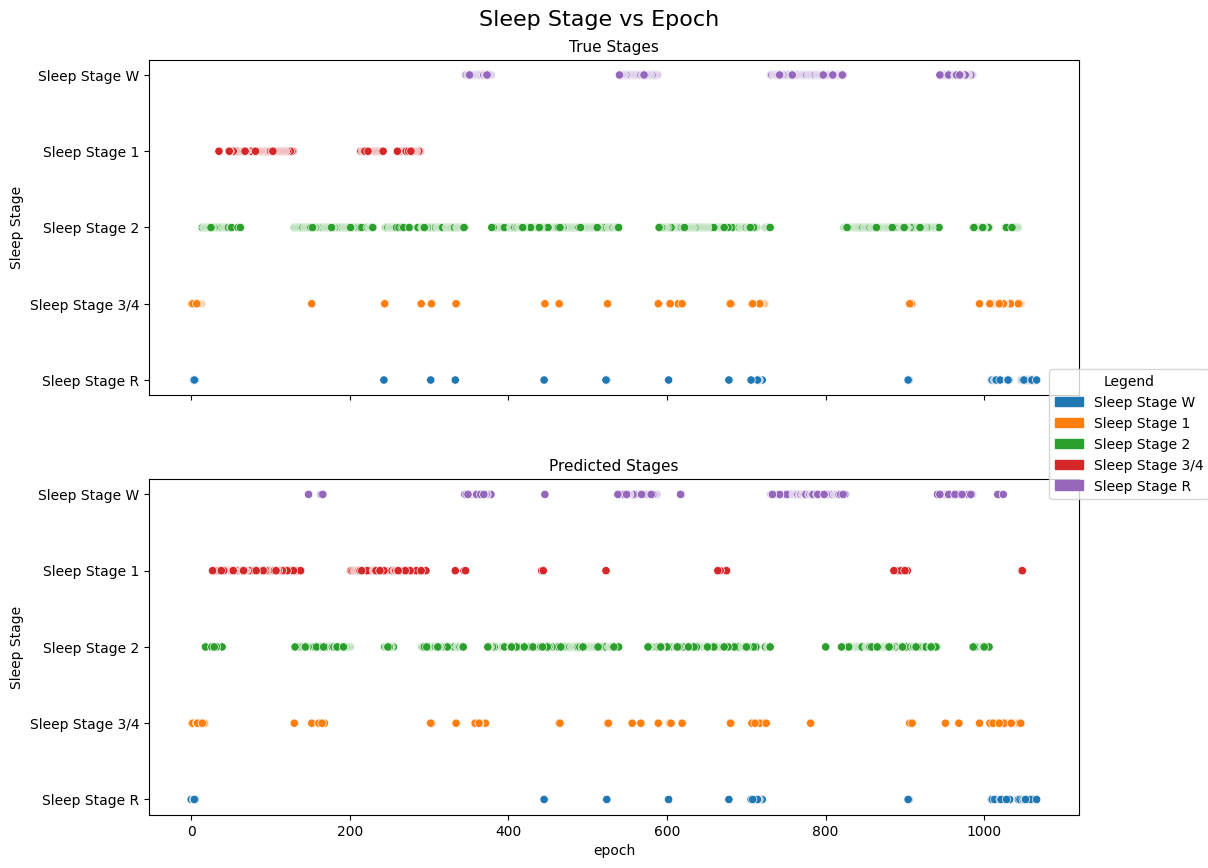

In [ ]:
epoch_plot(predictions_2)